<a href="https://colab.research.google.com/github/RemiJolian/Machine-Learning-Projects/blob/main/A_Guide_to_Deploying_ML_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Practical Guide to Deploying Machine Learning Models

If you’re looking to learn more about deploying machine learning models, this guide is for you.

The steps involved in building and deploying ML models can typically be summed up like so: building the model, creating an API to serve model predictions, containerizing the API, and deploying to the cloud.

This guide focuses on the following:

- Building a machine learning model with Scikit-learn
- Creating a REST API to serve predictions from the model using FastAPI
- Containerizing the API using Docker

We’ll build a simple regression model on the California housing dataset to predict house prices. By the end, you’ll have a containerized application that serves house price predictions based on selected input features.

# **Setting Up the Project Environment**
Before you start, make sure you have the following installed:

- A recent version of Python (Python 3.11 or later preferably)
- ocker for containerization; Get Docker for your operating system


##  **Getting** **Started**
Here’s the (recommended) structure for the project’s directory:

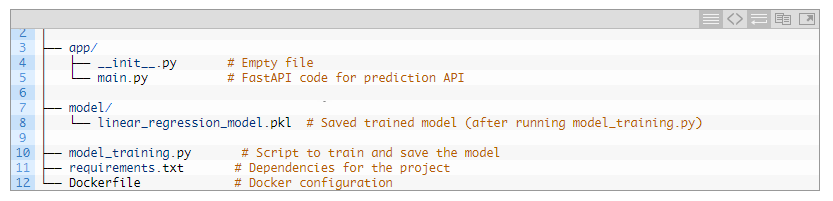

## **Create an virtual environment**
In your project environment, create and activate a virtual environment(e.g: v1):

In [ ]:
python.exe -m venv v1

In [ ]:
.\v1\Scripts\activate

For the project we’ll be working on, we need pandas and scikit-learn to build the machine learning model. And FastAPI and Uvicorn to build the API to serve the model’s predictions.

So let’s install these required packages using pip:

In [ ]:
pip install pandas scikit-learn fastapi uvicorn

# **Building a Machine Learning Model**
Now, we’ll train a linear regression model using the California Housing dataset which is built into scikit-learn. This model will predict house prices based on the selected features. In the project directory, create a file called model_training.py:

In [ ]:
# model_training.py
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pickle
import os

# Load the dataset
data = fetch_california_housing(as_frame=True)
df = data['data']
target = data['target']

# Select a few features
selected_features = ['MedInc', 'AveRooms', 'AveOccup']
X = df[selected_features]
y = target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Create a 'model' folder to save the trained model
os.makedirs('model', exist_ok=True)

# Save the trained model using pickle
with open('model/linear_regression_model.pkl', 'wb') as f:
	pickle.dump(model, f)

print("Model trained and saved successfully.")

This script loads the California housing dataset, selects three features (MedInc, AveRooms, AveOccup), trains a linear regression model, and saves it in the model/ folder as linear_regression_model.pkl.

Run the script to train the model and save it:

In [ ]:
python3 model_training.py

You’ll get the following message and should be able to find the .pkl file in the model/ directory:

**Model trained and saved successfully.**


# **Creating the FastAPI App**
We’ll now create an API that serves predictions using FastAPI.

Inside the app/ folder, create two files: **___init_ __.py** (empty) and **main.py**. We do this because we’d like to containerize the **FastAPI** app using **Docker** next.

In main.py, write the following code:

In [ ]:
# app/main.py
from fastapi import FastAPI
from pydantic import BaseModel
import pickle
import os

# Define the input data schema using Pydantic
class InputData(BaseModel):
    MedInc: float
    AveRooms: float
    AveOccup: float

# Initialize FastAPI app
app = FastAPI(title="House Price Prediction API")

# Load the model during startup
model_path = os.path.join("model", "linear_regression_model.pkl")
with open(model_path, 'rb') as f:
    model = pickle.load(f)

@app.post("/predict")
def predict(data: InputData):
    # Prepare the data for prediction
    input_features = [[data.MedInc, data.AveRooms, data.AveOccup]]

    # Make prediction using the loaded model
    prediction = model.predict(input_features)

    # Return the prediction result
    return {"predicted_house_price": prediction[0]}

This FastAPI application exposes a /predict endpoint that takes three features (MedInc, AveRooms, AveOccup). It uses the trained model to predict house prices, and returns the predicted price

# **Containerizing the App with Docker**
Now let’s containerize our FastAPI application. In the project’s root directory, create a **Dockerfile** and a **requirements.txt** file.

## Creating the Dockerfile
Let’s create a Dockerfile:

In [ ]:
# Use Python 3.11 as the base image
FROM python:3.11-slim

# Set the working directory inside the container
WORKDIR /code

# Copy the requirements file
COPY ./requirements.txt /code/requirements.txt

# Install the Python dependencies
RUN pip install --no-cache-dir --upgrade -r /code/requirements.txt

# Copy the app folder into the container
COPY ./app /code/app

# Copy the model directory (with the saved model file) into the container
COPY ./model /code/model

# Expose port 80 for FastAPI
EXPOSE 80

# Command to run the FastAPI app with Uvicorn
CMD ["uvicorn", "app.main:app", "--host", "0.0.0.0", "--port", "80"]

This creates a lightweight container for a FastAPI application using Python 3.11 (slim version) as the base image. It sets the working directory to /code, copies the requirements.txt file into the container, and installs the necessary Python dependencies without caching.

The FastAPI app and model files are then copied into the container. Port 80 is exposed for the application, and Uvicorn is used to run the FastAPI app. This makes the API accessible at port 80. This setup is efficient for deploying a FastAPI app in a containerized environment.

# **Creating the requirements.txt File**
Create a requirements.txt file listing all dependencies:

fastapi

uvicorn

scikit-learn

pandas

# **Building the Docker Image**
Now that we have the Dockerfile, requirements.txt, and the FastAPI app ready, let’s build a Docker image and run the container.

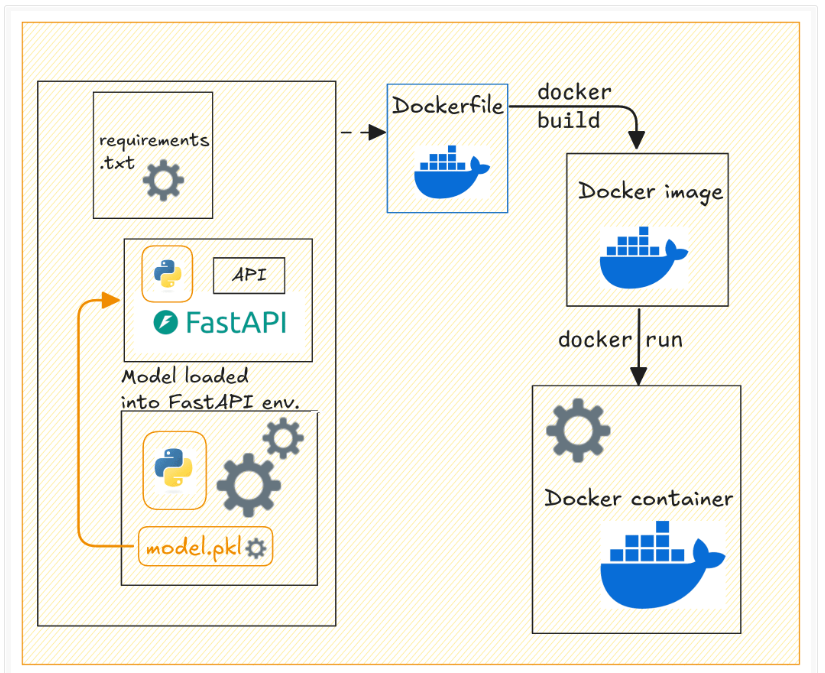

Build the Docker image by running the following docker build command:

In [ ]:
docker build -t house-price-prediction-api .

Next run the Docker container:

In [ ]:
docker run -d -p 80:80 house-price-prediction-api

Your API should now be running and accessible at http://127.0.0.1:80.


You can use **curl** or **Postman** to test the /predict endpoint by sending a POST request. Here’s an example request:

In [ ]:
curl -X POST "http://127.0.0.1:80/predict" -H "Content-Type: application/json" -d "{\"MedInc\": 3.5, \"AveRooms\": 5.0, \"AveOccup\": 2.0}"


# **Tagging and Pushing the Docker Image to Docker Hub**
After building the Docker image, running the container, and testing it. You can now push it to Docker Hub for easier sharing and deploying to cloud platforms.

First, login to Docker Hub:

In [ ]:
docker login

You’ll be prompted to enter the credentials.

Tag the Docker image:

In [ ]:
docker tag house-price-prediction-api your_username/house-price-prediction-api:v1

Replace your_username with your Docker Hub username.

**Note**: It also makes sense to add versions to your model files. When you update the model, you can rebuild the image with a new tag, and push the updated image to Docker Hub.

## Push the image to Docker Hub:

In [ ]:
docker push your_username/house-price-prediction-api:v1$ docker push your_username/house-price-prediction-api:v1

Other developers can now pull and run the image like so:

In [ ]:
docker pull your_username/house-price-prediction-api:v1
docker run -d -p 80:80 your_username/house-price-prediction-api:v1

### Anyone with access to your Docker Hub repository can now pull the image and run the container.

## Wrap-up and Next Steps
Here’s a quick review of what we did in this tutorial:

Train a machine learning model using scikit-learn
Build a FastAPI application to serve predictions
Containerize the application with Docker
We also looked at pushing the Docker image to Docker Hub for easier distribution. The next logical step is to deploy this containerized application to the cloud.

And for this, you can use services like AWS ECS, GCP, or Azure to deploy the API in a production environment

### **Thanks to:**

My Ref: https://machinelearningmastery.com/